# A Deep Hedging experiment in the Heston model.
This code will implement a deep hedging experiment in the heston model with the stock and Swap the tradeable assets.

In [41]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate, SimpleRNN, LSTM, GRU, BatchNormalization
from keras.models import Model
from keras import backend as kb
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tfnp
import copy
plt.style.use('ggplot')
%run Fourier.ipynb #imports Heston option prices
%run Path_simulation.ipynb #imports path simulation functions
%run Loss_functions.ipynb #imports Loss_functions used
%run Neural_Networks.ipynb #imports different types of NN
%run Analytic_Heston.ipynb #imports function for S2 price calculation and analytic deltas.

In [42]:
#parameters used - mainly from Buehler Deep Hedging paper.

#¤What about feller condition? 2\kappa\theta>\sigma^2 for V_t>0 for all t\in[0,T]
kappa = 1#rate of mean reversion
theta = 0.04#long term variance
rho = -0.7#correlation b/t BM
sigma = 0.2#vol of vol -¤sigma=2 in paper, but maybe it should be 0.2 b/c of Feller condition
V0 = 0.04#initial vol
r = 0
mu = 0.05

S0 = 100#initial price
n = 100000#number of paths
K = 100#strike
divyield=0
steps = 30#number of rebalancings
epochs = 50#Number of times model is trained
#new variables
T = 30/365#time to expiry
dt = T/steps #step size

#for call spread option
K1=99
K2=100

#Expected shortfall at level 1-alpha
alpha=0.99

#Transaction cost
TC=False
epsilon=0.01

#Consider calling the epsilon variable, sigma, instead
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)

In [43]:
sigma=10
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)

In [44]:
call_long=HestonFourier(spot=S0, timetoexp=T, strike=K1, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
call_short=HestonFourier(spot=S0, timetoexp=T, strike=K2, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)
callspread_price=(call_long-call_short)/(K2-K1)

In [45]:
S1,vol,S2 = HestonMomentMatching_SV(n)
#S1,vol,S2 = HestonFullTruncation_SV(n)
tSVinput,dSVoutput = DataInputOutput_HSV(S1,vol,S2) 

In [46]:
tSVinput2,dSVoutput2 = RNN_DataInputOutput_HSV(S1,vol,S2) 

In [47]:
tSVinput2.shape

(100000, 30, 3)

In [48]:
tSVinput[0]

array([[0.        , 4.60517019, 0.04      ],
       [0.        , 4.60517019, 0.04      ],
       [0.        , 4.60517019, 0.04      ],
       ...,
       [0.        , 4.60517019, 0.04      ],
       [0.        , 4.60517019, 0.04      ],
       [0.        , 4.60517019, 0.04      ]])

In [49]:
dSVoutput.shape

(100000, 60)

In [50]:
dSVoutput2.shape

(100000, 30, 2)

In [51]:
S1.min()

3.227011567713709

In [52]:
vol.min()

3.204242004734618e-11

In [53]:
vol.max()

34.66887828801357

In [54]:
digiprice = np.mean(S1.T[steps]>K)#this MC pricing should be under the Q measure. 

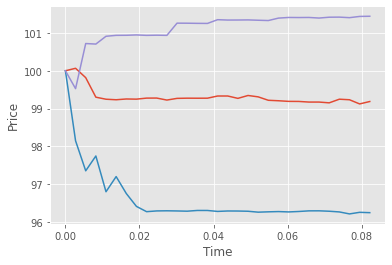

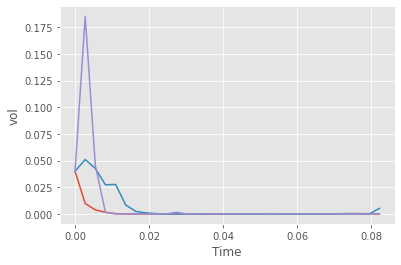

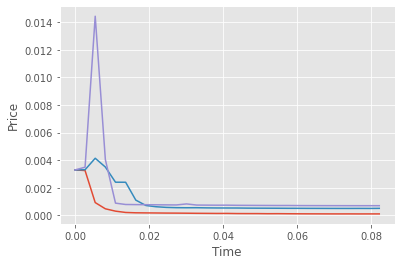

In [55]:
#This just plots the three first paths as a sanity check (Stock, vol and var SWAP)
#From the plot we see that S2 have similar trends as vol. This is promising.
#Also the plots looks like German Tobias plots.

tim = np.linspace(0,T,steps+1)#Vector of timepoint where pf i adjusted.

plt.plot(tim,S1[0],tim,S1[1],tim,S1[2])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()
plt.plot(tim,vol[0],tim,vol[1],tim,vol[2])
plt.xlabel("Time")
plt.ylabel("vol")
plt.show()
plt.plot(tim,S2[0],tim,S2[1],tim,S2[2])
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [56]:
TC=False

In [57]:
K=85
callprice=HestonFourier(spot=S0, timetoexp=T, strike=K, r=0, divyield=0, V=V0, theta=theta, kappa=kappa, epsilon=sigma, rho=rho, greek=1)

In [58]:
model=FFNN('linear',3,2,loss_call)

In [59]:
model.fit(tSVinput,dSVoutput,batch_size=100,epochs=50)

Epoch 1/50
1000/1000 [==============================] - 26s 20ms/step - loss: 2.5435
Epoch 2/50
1000/1000 [==============================] - 28s 28ms/step - loss: 1.9226
Epoch 3/50
1000/1000 [==============================] - 26s 26ms/step - loss: 1.3857
Epoch 4/50
1000/1000 [==============================] - 26s 26ms/step - loss: 1.0039
Epoch 5/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.9904
Epoch 6/50
1000/1000 [==============================] - 24s 24ms/step - loss: 0.9120
Epoch 7/50
1000/1000 [==============================] - 26s 26ms/step - loss: 0.9467
Epoch 8/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.9013
Epoch 9/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.8608
Epoch 10/50
1000/1000 [==============================] - 25s 25ms/step - loss: 0.8068
Epoch 11/50
1000/1000 [==============================] - 24s 24ms/step - loss: 0.7813
Epoch 12/50
1000/1000 [==============================] - 23s 23

KeyboardInterrupt: 

In [ ]:
#model.save('Heston_FFNN_30days_30steps')

In [ ]:
#model.save('Heston_TC_0_01_FFNN_30days_30steps')

# Call spread NN plots

In [ ]:
#first evaluate model on new dataset.
n=100000
S,vol,S2 = HestonMomentMatching_SV(n)
input_eval,dS_eval = DataInputOutput_HSV(S,vol,S2)

In [ ]:
deltas=model.predict(input_eval)

In [ ]:
deltas_tf=tf.convert_to_tensor(deltas,dtype='float64')
dS_eval_tf=tf.convert_to_tensor(dS_eval,dtype='float64')

payoff=(np.maximum(S.T[steps]-K1,0)-np.maximum(S.T[steps]-K2,0))/(K2-K1)
PfValue=np.sum(dS_eval*deltas,axis=(-1))-TC*Proportional_cost(dS_eval_tf,deltas_tf)#axis=-1 when FFNN, axis=(1,2) when RNN
Error=np.array(PfValue-payoff)#What we get in the bank at expiry

In [ ]:
print('TC are: ',kb.mean(Proportional_cost(dS_eval_tf,deltas_tf)))
print('Mean of Hedge error is: ',np.mean(Error))
print('sd of hedge error is: ',np.std(Error))

In [ ]:
#¤consider making the Histogram as Loss, hence -1*Error
#(np.histogram(Error,bins=100))
a = np.hstack(-Error-callspread_price)
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Loss of NN Hedging pf")
plt.show()

In [ ]:
x=S.T[steps]#This is X-axis
y=PfValue+callspread_price#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o')
plt.plot([min_S, K1], [0, 0],color='b')
plt.plot([K1, K2], [0, 1],color='b')
plt.plot([K2, max_S], [1, 1],color='b')
plt.title("Option payoff vs. NN hedge payoff")
plt.show()

# Digital NN plots

In [ ]:
#first evaluate model on new dataset.
n=100000
S,vol,S2 = HestonMomentMatching_SV(n)
input_eval,dS_eval = DataInputOutput_HSV(S,vol,S2)

In [ ]:
deltas=model.predict(input_eval)

In [ ]:
deltas_tf=tf.convert_to_tensor(deltas,dtype='float64')
dS_eval_tf=tf.convert_to_tensor(dS_eval,dtype='float64')

payoff=(S.T[steps]>K)*1
PfValue=np.sum(dS_eval*deltas,axis=(-1))-TC*Proportional_cost(dS_eval_tf,deltas_tf)#axis=-1 when FFNN, axis=(1,2) when RNN
Error=np.array(PfValue-payoff)#What we get in the bank at expiry

In [ ]:
print('TC are: ',kb.mean(Proportional_cost(dS_eval_tf,deltas_tf)))
print('Mean of Hedge error is: ',np.mean(Error))
print('sd of hedge error is: ',np.std(Error))

In [ ]:
#¤consider making the Histogram as Loss, hence -1*Error
#(np.histogram(Error,bins=100))
a = np.hstack(-Error)
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Loss of NN Hedging pf")
plt.show()

In [ ]:
x=S.T[steps]#This is X-axis
y=PfValue#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o')
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [1, 1],color='b')
#plt.plot([0, K], [0, 0],color='b'
#plt.plot([K, K*2], [0, K],color='b')
plt.title("Option payoff vs. NN hedge payoff")
plt.show()

In [ ]:
deltas

In [ ]:
#digital vs. call spread payoff

min_S=95
max_S=105
plt.plot([min_S, K], [0, 0],color='b',alpha=0.7)
plt.plot([K, max_S], [1, 1],color='b',alpha=0.7)

plt.plot([min_S, K-1], [0, 0],color='r',alpha=0.7)
plt.plot([K-1, K], [0, 1],color='r',alpha=0.7)
plt.plot([K, max_S], [1, 1],color='r',alpha=0.7)
#plt.plot([0, K], [0, 0],color='b'
#plt.plot([K, K*2], [0, K],color='b')
plt.title("Digital option payoff vs. call spread option payoff")
plt.show()

# Plotting NN
We start by calculating basic thing used for Histogram and Hockey Stick.

In [ ]:
#model=load_model('Heston_FFNN_30days_30steps', compile=False)

In [ ]:
#first evaluate model on new dataset.
n=100000
S,vol,S2 = HestonMomentMatching_SV(n)
input_eval,dS_eval = DataInputOutput_HSV(S,vol,S2)

In [ ]:
input_eval,dS_eval = DataInputOutput_HSV(S,vol,S2)

In [ ]:
input_eval,dS_eval = RNN_DataInputOutput_HSV(S,vol,S2)

In [ ]:
deltas=model.predict(input_eval)

In [ ]:
deltas_tf=tf.convert_to_tensor(deltas,dtype='float64')
dS_eval_tf=tf.convert_to_tensor(dS_eval,dtype='float64')

payoff=np.maximum(S.T[steps]-K,0)
PfValue=callprice+np.sum(dS_eval*deltas,axis=(-1))-TC*Proportional_cost(dS_eval_tf,deltas_tf)#axis=-1 when FFNN, axis=(1,2) when RNN
Error=np.array(PfValue-payoff)#What we get in the bank at expiry
#old version
#payoff=kb.maximum(S.T[steps]-K,0)
#PfValue=callprice+kb.sum(dS_eval*deltas,axis=-1)
#Error=(PfValue-payoff)#What we get in the bank at expiry

In [ ]:
print('TC are: ',kb.mean(Proportional_cost(dS_eval_tf,deltas_tf)))
print('Mean of Hedge error is: ',np.mean(Error))
print('sd of hedge error is: ',np.std(Error))

### Histogram 

In [ ]:
#¤consider making the Histogram as Loss, hence -1*Error
#(np.histogram(Error,bins=100))
a = np.hstack(-Error)
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Loss of NN Hedging pf")
plt.show()

### Hockey stick

In [ ]:
x=S.T[steps]#This is X-axis
y=PfValue#This is y-axis
min_S=np.min(x)
max_S=np.max(x)
plt.plot(x,y,'o')
plt.plot([min_S, K], [0, 0],color='b')
plt.plot([K, max_S], [0, max_S-K],color='b')
#plt.plot([0, K], [0, 0],color='b')
#plt.plot([K, K*2], [0, K],color='b')
plt.title("Option payoff vs. NN hedge payoff")
plt.show()

# Plotting RNN vs FFNN TC

In [ ]:
n_bins = 10
x = np.random.randn(1000, 3)

In [ ]:
x.shape

In [ ]:
np.array(Error_both).shape

In [ ]:
#insert values
Error_FFNN
Error_RNN

In [ ]:
Error_both=[]
for i in range(n):
    Error_both.append([Error_FFNN[i],Error_RNN[i]])
Error_both=np.array(Error_both)

In [ ]:
colors = ['red', 'blue']
plt.hist(-Error_both, 25, density=True, histtype='bar', color=["red","blue"], label=["FFNN","RNN"])
plt.legend(prop={'size': 10})
plt.title("FFNN(red) vs RNN(blue) hedge error with TC=0.01")
#red=FFNN, blue=RNN

In [ ]:
a = np.hstack(-Error)
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Loss of NN Hedging pf")
plt.show()

# Plotting analytic model

In [ ]:
timepoints = np.linspace(0,T-dt,steps)#Vector of timepoint where pf i adjusted.

model_deltas=np.empty((n,steps*2))
for i in range(n):
    tmp_delta=np.empty(0)
    for j in range(steps):
        delta1,delta2=delta12(t=timepoints[j],v=vol[i][j],s=S[i][j])
        tmp_delta=np.append(tmp_delta,delta1)
        tmp_delta=np.append(tmp_delta,delta2)
    model_deltas[i]=tmp_delta

In [ ]:
tSVinput[0].shape

In [ ]:
dSVoutput[0]

In [ ]:
n=stop

In [ ]:
model_deltas[:stop].shape

In [ ]:
#S_total=S
#vol_total=vol
#S2_total=S2
#input_eval_total=input_eval
#dS_eval_total=dS_eval
#model_deltas_total=model_deltas

In [ ]:
S=S[:stop]
vol=vol[:stop]
S2=S2[:stop]
input_eval=input_eval[:stop]
dS_eval=dS_eval[:stop]
model_deltas=model_deltas[:stop]

In [ ]:
payoff=kb.maximum(S.T[steps]-K,0)
PfValue_model=callprice+kb.sum(dS_eval*model_deltas,axis=-1)
Error_model=np.array(PfValue_model-payoff)#What we get in the bank at expiry

### Histogram

In [ ]:
#(np.histogram(Error,bins=100))
a_model = np.hstack(Error_model)
_ = plt.hist(a_model, bins='auto')  # arguments are passed to np.histogram
plt.title("Error of model Hedging pf")
plt.show()

### Hockey stick

In [ ]:
x=S.T[steps]#This is X-axis
y=PfValue_model#This is y-axis
plt.plot(x,y,'o')
plt.plot([0, K], [0, 0],color='b')
plt.plot([K, K*2], [0, K],color='b')
plt.title("Option payoff vs. Model hedge payoff")
plt.show()

In [ ]:
print(np.mean(Error_model))
print(np.std(Error_model))

# 3D plot

In [ ]:
#¤make the code flexible so it can handle S_idx and vol_idx being adjusted...
time = T/2
S_idx=10
vol_idx=10

Sval = np.linspace(95,103,num=S_idx)
volval = np.linspace(.03,.13,num=vol_idx)

SGrid,volGrid=np.meshgrid(Sval,volval)

In [ ]:
tSinput_3d = []
tim = np.linspace(T/2,T/2,steps+1)

n_3d=1

for i in range(10):
    for j in range(10):
        timv = np.repeat(tim[i],n_3d)
        timv = np.reshape(timv,(n_3d,1))
        Sv = np.reshape(SGrid[i][j],(n_3d,1))
        volv = np.reshape(volGrid[i][j],(n_3d,1))
        tSinput_3d.append(np.concatenate((timv,Sv,volv),1))#Input is (t,S,v)

delta_3d=model.predict(tSinput_3d)
delta_3d_1=delta_3d[0][::2]
delta_3d_2=delta_3d[0][1::2]

delta1_NN = np.zeros([10,10])
delta2_NN = np.zeros([10,10])

for i in range(10):
    for j in range(10):
        delta1_NN[i][j]=delta_3d_1[i*10+j]
        delta2_NN[i][j]=delta_3d_2[i*10+j]

In [ ]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta1_NN, 100)
ax.set_xlabel('S')
ax.set_ylabel('vol')
ax.set_zlabel('delta1');
plt.title("NN delta1")

In [ ]:
fig_nn = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta2_NN, 100)
ax.set_xlabel('S')
ax.set_ylabel('vol')
ax.set_zlabel('delta2');
plt.title("NN delta2")

In [ ]:
delta1_model = np.zeros([10,10])
delta2_model = np.zeros([10,10])

for i in range(10):
    for j in range(10):
        delta1,delta2=delta12(t=tSinput_3d[i*10+j][0][0],s=tSinput_3d[i*10+j][0][1],v=tSinput_3d[i*10+j][0][2])
        delta1_model[i][j]=delta1
        delta2_model[i][j]=delta2

In [ ]:
fig_model = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta1_model, 100)
ax.set_xlabel('S')
ax.set_ylabel('vol')
ax.set_zlabel('delta1');
plt.title("Model delta1")

In [ ]:
fig_model = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta2_model, 100)
ax.set_xlabel('S')
ax.set_ylabel('vol')
ax.set_zlabel('delta2');
plt.title("Model delta2")

In [ ]:
delta1_diff=delta1_NN-delta1_model
delta2_diff=delta2_NN-delta2_model

In [ ]:
fig_model = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta1_diff, 100)
ax.set_xlabel('S')
ax.set_ylabel('vol')
ax.set_zlabel('delta1');
plt.title("Diff delta1")

In [ ]:
fig_model = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(SGrid, volGrid, delta2_diff, 100)
ax.set_xlabel('S')
ax.set_ylabel('vol')
ax.set_zlabel('delta1');
plt.title("Diff delta2")

In [ ]:
delta1_diff.min() 

# Saving/Loading data

In [ ]:
import dill
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

# test of transaction cost
Do test with tensor datatype

In [ ]:
model=load_model('Heston_Swap_30days_30steps', compile=False)

In [ ]:
n=100000
S,vol,S2 = HestonMomentMatching_SV(n)
input_eval,dS_eval = DataInputOutput_HSV(S,vol,S2)

In [ ]:
deltaer=model.predict(input_eval)

In [ ]:
deltas=tf.convert_to_tensor(deltaer[:100],dtype='float64')
dS=tf.convert_to_tensor(dS_eval[:100],dtype='float64')

In [ ]:
def Proportional_cost(dS,deltas):#we could also call the input y_pred,y_true,epsilon
    
    #finding changes to pf.
    delta1=deltas[:,::2]
    delta2=deltas[:,1::2]
    
    #for initial TC
    delta1_t0=delta1[:,0]
    delta2_t0=delta2[:,0]
    
    #for terminal TC
    delta1_tT=delta1[:,steps-1]
    delta2_tT=delta2[:,steps-1]
    
    #for intermediate TC
    #finding changes to pf.
    delta1_I=kb.abs(tf.subtract(delta1[:,1:],delta1[:,:-1]))
    delta2_I=kb.abs(tf.subtract(delta2[:,1:],delta2[:,:-1]))
    
    #finding asset prices.
    dS1=dS[:,::2]
    dS2=dS[:,1::2]
    S1=tf.math.cumsum(dS1)+S0
    S2=tf.math.cumsum(dS2)+L(0,V0)#L function is initial price of Swap
    
    #for initial TC
    S1_t0=S0
    S2_t0=L(0,V0)
    
    #for terminal TC
    S1_tT=S1[:,steps-1]
    S2_tT=S2[:,steps-1]
    
    #for intermediate TC.
    #(We remove the price in the last time step)
    S1_I=tf.slice(S1,[0,0],[S1.get_shape()[0],steps-1])
    S2_I=tf.slice(S2,[0,0],[S2.get_shape()[0],steps-1])
    
    #initial TC
    TCS1_0=epsilon*kb.abs(delta1_t0)*S1_t0
    TCS2_0=epsilon*kb.abs(delta2_t0)*S2_t0
    
    #Terminal TC
    TCS1_T=epsilon*kb.abs(delta1_tT)*S1_tT
    TCS2_T=epsilon*kb.abs(delta2_tT)*S2_tT
    
    #Intermediate TC
    TCS1_I=epsilon*kb.sum(delta1_I*S1_I,axis=1)
    TCS2_I=epsilon*kb.sum(delta2_I*S2_I,axis=1)
    
    Cost=TCS1_0+TCS2_0+TCS1_I+TCS2_I#+TCS1_T+TCS2_T
    return Cost

#consider implementing other types of transacton cost

In [ ]:
TC=True

In [ ]:
model=FFNN('linear',3,2,loss_call)

In [ ]:
model.fit(tSVinput,dSVoutput,batch_size=100,epochs=50)

# Playing with RNN

In [ ]:
#S1,vol,S2 = HestonMomentMatching_SV(n)
tSVinput_RNN,dSVoutput_RNN = RNN_DataInputOutput_HSV(S1,vol,S2) 

In [ ]:
#¤This model is good, but might not be what they do in the article
model_input=Input(shape=(steps,3))
x=SimpleRNN(100,return_sequences=True,activation='relu')(model_input)
x=SimpleRNN(100,return_sequences=True,activation='relu')(x)
x=SimpleRNN(100,return_sequences=True,activation='relu')(x)
output=Dense(2,activation='linear')(x)
model=Model(inputs=model_input,outputs=output)
model.compile(optimizer='adam',loss=loss_call_RNN)
model.summary()

In [ ]:
model.fit(tSVinput,dSVoutput,batch_size=100,epochs=40)

In [ ]:
#See how well this performs.
#This is my best attempt at doing exactly what they do in the article. 
#But we need to make sure exactly what is going on.
#¤try to work with relu activation and add a dense layer with linear activation.
n_units=100
n_layers=3
inputs = Input(shape=(steps,3))
cells=[tf.keras.layers.GRUCell(n_units) for _ in range(n_layers)]
outputs = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(cells),
                              stateful=False, 
                              return_sequences=True, 
                              return_state=False)(inputs)
outputs = tf.keras.layers.Dense(2)(outputs)
model=Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(optimizer='adam',loss=loss_call_RNN)

In [ ]:
model.fit(tSVinput_RNN,dSVoutput_RNN,batch_size=100,epochs=10)

In [ ]:
#the same as above but with SimpleRNN and linear activation at output.
#the deltas from the network seem to be way better than for the above two RNN.
n_units=100
n_layers=3
inputs = Input(shape=(steps,3))
cells=[tf.keras.layers.SimpleRNNCell(n_units,activation='relu') for _ in range(n_layers)]
outputs = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(cells),
                              stateful=False, 
                              return_sequences=True, 
                              return_state=False)(inputs)
outputs = tf.keras.layers.Dense(2,activation='linear')(outputs)
model=Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(optimizer='adam',loss=loss_call_RNN)

In [ ]:
model.fit(tSVinput_RNN,dSVoutput_RNN,batch_size=100,epochs=50)

In [ ]:
model.save('Heston_RNN_30days_30steps')#it gives some warnings, but it should be alright.

In [ ]:
#modelRNN=load_model('Heston_RNN_30days_30steps', compile=False)

# RNN and TC TEST

In [ ]:
n=100000
S,vol,S2 = HestonMomentMatching_SV(n)
input_eval_RNN,dS_eval_RNN = RNN_DataInputOutput_HSV(S,vol,S2)

In [ ]:
deltaer=model.predict(input_eval_RNN)

In [ ]:
deltas=tf.convert_to_tensor(deltaer[:100],dtype='float64')
dS=tf.convert_to_tensor(dS_eval[:100],dtype='float64')

In [ ]:
kb.mean(Proportional_cost_RNN(dS,deltas))

In [ ]:
#the same as above but with SimpleRNN and linear activation at output.
#the deltas from the network seem to be way better than for the above two RNN.
n_units=100
n_layers=3
inputs = Input(shape=(steps,3))
cells=[tf.keras.layers.SimpleRNNCell(n_units,activation='relu') for _ in range(n_layers)]
outputs = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(cells),
                              stateful=False, 
                              return_sequences=True, 
                              return_state=False)(inputs)
outputs = tf.keras.layers.Dense(2,activation='linear')(outputs)
model=Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(optimizer='adam',loss=loss_call_RNN)

In [ ]:
model.fit(tSVinput_RNN,dSVoutput_RNN,batch_size=100,epochs=50)

In [ ]:
model.save('Heston_TC_0_01_RNN_30days_30steps')

In [ ]:
model_RNN_TC=model

# Loss ES test

In [ ]:
model=load_model('Heston_FFNN_30days_30steps', compile=False)

In [ ]:
n=100000
S,vol,S2 = HestonMomentMatching_SV(n)
input_eval,dS_eval = DataInputOutput_HSV(S,vol,S2)
deltaer=model.predict(input_eval)

In [ ]:
deltas=tf.convert_to_tensor(deltaer[:100],dtype='float64')
dS=tf.convert_to_tensor(dS_eval[:100],dtype='float64')

In [ ]:
deltas * dS

In [ ]:

#insert if else TC statement

pf_loss=(callprice + kb.sum(deltas * dS,axis=-1) - kb.maximum(S0 + kb.sum(dS,axis=-1) - K,0.))#do we need a minus here?
sortet = tf.sort(pf_loss)
cutoff = int(tfnp.floor(alpha*sortet.shape[0]))
quantile = sortet[:cutoff]
ES_alpha = -kb.mean(quantile)

In [ ]:
loss_ES(dS,deltas)

In [ ]:
TransactionCost=0
pf_loss=(callprice + kb.sum(deltas * dS,axis=-1) - kb.maximum(S0 + kb.sum(dS,axis=-1) - K,0.)-TransactionCost)#do we need a minus here?

In [ ]:
int(alpha*pf_loss.shape[0])

In [ ]:
tf.sort(pf_loss)[:5]

In [ ]:
tf.math.top_k(-pf_loss,int(0.05*pf_loss.shape[0]))

In [ ]:
lol,hej=tf.math.top_k(-pf_loss,int(0.05*pf_loss.shape[0]))

In [ ]:
kb.mean(lol)

In [ ]:
hej

In [ ]:
pf_losss=-(callprice + kb.sum(deltas * dS,axis=-1) - kb.maximum(S0 + kb.sum(dS,axis=-1) - K,0.)-TransactionCost)
quantiles,idx=tf.math.top_k(pf_losss,tf.cast((alpha)*pf_loss.shape[0], tf.int32))
ES_alphas=kb.mean(quantiles)
ES_alphas

In [ ]:
pf_loss

In [ ]:
    if TC==True:
        TransactionCost=kb.mean(Proportional_cost(y_true,y_pred))
    else:
        TransactionCost=0
    #we have a minus in front b/c we need the loss
    pf_loss=-(callprice + kb.sum(deltas * dS,axis=-1) - kb.maximum(S0 + kb.sum(dS,axis=-1) - K,0.)-TransactionCost)
    quantile,idx=tf.math.top_k(pf_loss,int(0.05*pf_loss.shape[0]))
    ES_alpha=kb.mean(quantile)
    #sortet = tf.sort(pf_loss)
    #cutoff = int(tfnp.floor(alpha*sortet.shape[0]))
    #quantile = sortet[:cutoff]
    #ES_alpha = -kb.mean(quantile)
    ES_alpha

In [ ]:
tf.cast(ES_alpha,dtype='float64')

In [ ]:
tf.repeat(ES_alpha,pf_loss.shape[0])

In [ ]:
pf_loss[0]=ES_alpha

In [ ]:
tf.reduce_mean(quantile)

In [ ]:
quantile

In [ ]:
alpha=0.05

In [ ]:
loss_ES(dS,deltas)

In [ ]:
loss_ES(dS,deltas)

In [ ]:
y_pred=deltas
y_true=dS

In [ ]:
pf_loss=(callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S0 + kb.sum(y_true,axis=-1) - K,0.)-TransactionCost)#do we need a minus here?
sortet = tf.sort(pf_loss)
cutoff = int(tfnp.floor(alpha*sortet.shape[0]))
quantile = sortet[:cutoff]
ES_alpha = -kb.mean(quantile)
ES_alpha

In [ ]:
quantile

In [ ]:
quantiles

In [ ]:
TC

In [ ]:
def loss_ES(y_true,y_pred):
    if TC==True:
        TransactionCost=kb.mean(Proportional_cost(y_true,y_pred))
    else:
        TransactionCost=0
    pf_loss=(callprice + kb.sum(deltas * dS,axis=-1) - kb.maximum(S0 + kb.sum(dS,axis=-1) - K,0.)-TransactionCost)#do we need a minus here?
    sortet = tf.sort(pf_loss)
    cutoff = int(tfnp.floor(alpha*sortet.shape[0]))
    quantile = sortet[:cutoff]
    ES_alpha = -kb.mean(quantile)
    return ES_alpha

In [ ]:
def loss_ES_RNN(y_true,y_pred):
    if TC==True:
        TransactionCost=kb.mean(Proportional_cost_RNN(y_true,y_pred))
    else:
        TransactionCost=0
    pf_loss = (callprice + kb.sum(y_pred * y_true,axis=(1,2)) - kb.maximum(S0 + kb.sum(y_true,axis=(1,2)) - K,0.)-TransactionCost)
    sortet = tf.sort(pf_loss)
    cutoff = int(tfnp.floor(alpha*sortet.shape[0]))
    quantile = sortet[:cutoff]
    ES_alpha = -kb.mean(quantile)

In [ ]:
def loss_call_RNN(y_true,y_pred):
    if TC==True:
        TransactionCost=kb.mean(Proportional_cost_RNN(y_true,y_pred))
    else:
        TransactionCost=0
    return (callprice + kb.sum(y_pred * y_true,axis=(1,2)) - kb.maximum(S0 + kb.sum(y_true,axis=(1,2)) - K,0.)-TransactionCost)**2

In [ ]:
def loss_call(y_true,y_pred):
    if TC==True:
        TransactionCost=kb.mean(Proportional_cost(y_true,y_pred))
    else:
        TransactionCost=0
    return (callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S0 + kb.sum(y_true,axis=-1) - K,0.)-TransactionCost)**2
#ES

In [ ]:
# RNN_cell test
S1,vol,S2 = HestonFullTruncation_SV(n)
tSVinput,dSVoutput = RNN_DataInputOutput_HSV(S1,vol,S2)

In [ ]:
m1=RNN_cell('linear',3,2,loss_call_RNN)

In [ ]:
m1.summary()

In [ ]:
m1.summary()

In [ ]:
#maybe this is in fact what we want.
def RNN_cell_plus_out(output_activation,Input_shape,Output_shape,loss_function):
    n_unit=[100,100,100,Output_shape]
    act=['relu','relu','relu',output_activation]
    n_layers=4
    inputs = Input(shape=(steps,Input_shape))
    cells=[tf.keras.layers.SimpleRNNCell(n_unit[i],activation=act[i]) for i in range(n_layers)]
    outputs = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(cells),
                                  stateful=False, 
                                  return_sequences=True, 
                                  return_state=False)(inputs)
    model=Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',loss=loss_function)
    return model

In [ ]:
m2=RNN_cell_plus_out('linear',3,2,loss_call_RNN)

In [ ]:
m2.fit(tSVinput,dSVoutput,batch_size=100,epochs=50)

In [ ]:
model.summary()

In [ ]:
def RNN_cell(output_activation,Input_shape,Output_shape,loss_function):
    n_units=100
    n_layers=1
    inputs = Input(shape=(steps,Input_shape))
    cells=[tf.keras.layers.SimpleRNNCell(n_units,activation='relu') for _ in range(n_layers)]
    outputs = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(cells),
                              stateful=False, 
                              return_sequences=True, 
                              return_state=False)(inputs)
    outputs = tf.keras.layers.Dense(Output_shape,activation=output_activation)(outputs)
    model=Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',loss=loss_function)
    return model